### Make paths to directories

In [108]:
import sys
import os

# Get the path to the current working directory
current_dir = os.getcwd()

# Get the path to the parent directory (containing both A.py and 'B' directory)
parent_dir = os.path.dirname(current_dir)

london_data_dir = os.path.join(parent_dir, 'Data/Flanders_dataset/preprocces')
results_dir = os.path.join(current_dir, 'resultsFlanders')
# Append the parent directory to the module search path
sys.path.append(parent_dir)
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator

### Imports

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
from scengen.exp.experiment import ComparisonExperiment
from scengen.generators import PredClusGenerator, SampleGenerator, RandomGenerator
from data_preprocessing.get_buffer_attributes import BufferAttributesCalculator

import numpy as np
import pandas as pd
import pickle
import datetime
import inspect
from pathlib import Path


### DATA generators

In [128]:
random_gen = np.random.default_rng(12341)

def random_dataset(N):
    attributes = random_gen.random(size = (N, 25))
    timeseries = random_gen.random(size = (N, 24*4))
    folds = np.array_split(np.arange(0, N, dtype= 'int'), 5)
    return attributes, timeseries, folds

def flanders_dataset(london_data_dir=london_data_dir, attributes = "flandersattributues.pkl", timeseries = "flanderstimeseries.pkl"):
    #return [], [], []
    attributes_path = os.path.join(london_data_dir, attributes)
    timeseries_path = os.path.join(london_data_dir, timeseries)
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    folds = np.array_split(np.arange(0, len(attributes), dtype= 'int'), 5)

    return attributes, timeseries, folds

def flanders_dataset_with_buffer(buffer_attributes, london_data_dir = london_data_dir, attributes = "flandersattributues.pkl", timeseries = "flanderstimeseries.pkl", weekdays_only = True):
    #return [], [], []

    attributes_path = os.path.join(london_data_dir, attributes) #combined_attributes_filtered.pkl
    buffer_attributes_path = os.path.join(london_data_dir, buffer_attributes) #daily_data_df_filtered.pkl
    timeseries_path = os.path.join(london_data_dir, timeseries) #buffer_attributes_march_df.pkl
    attributes = pd.read_pickle(attributes_path)
    timeseries = pd.read_pickle(timeseries_path)
    buffer_attributes = pd.read_pickle(buffer_attributes_path)
    merged_attributes = attributes.merge(buffer_attributes,on=['meterID'], how="left")
    
    merged_attributes = merged_attributes.drop(columns=['kurtosis_weekend','skewness_weekend'])

    folds = np.array_split(np.arange(0, len(merged_attributes), dtype= 'int'), 5)

    return merged_attributes, timeseries, folds

In [112]:
def get_NaNs(df):
    NaN_counts = df.isna().sum()
    for column_name, na_count in NaN_counts.items():
        if na_count > 0:
            print(f"Column {column_name} has {na_count} missing values.")
 

# Hyperparameter Tuning

In [113]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlanders/Tuning'), nb_of_samples = 250)
    .add_methods(
        PCT_D4_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)),
        PCT_D6_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 100)),
        PCT_D8_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 100)),
        PCT_D4_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 175)),
        PCT_D6_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 175)),
        PCT_D8_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 175)),
        PCT_D4_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 250)),
        PCT_D6_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 250)),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D8_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 350)),
        PCT_D10_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 350)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D12_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 350)),
        PCT_D8_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 450)),
        PCT_D12_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 450)),
        PCT_D14_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 14, min_samples_leaf = 450)),
        PCT_D8_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 650)),
        PCT_D8_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 850)),
        PCT_D8_M1000 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 1000)),
    )
    .add_datasets(
        flanders_dataset_baseline = flanders_dataset(),
        )
)

energy_scores, timing_df = experiment.execute()





Methods: 100%|██████████| 20/20 [00:00<00:00, 76.82it/s, method=PCT_D8_M1000]


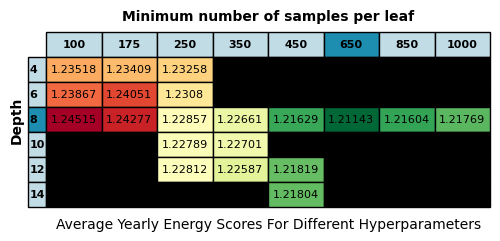

In [114]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(3, 2.5))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(-0.55, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('Pictures/tuningflandersbaseline.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [115]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlanders/TuningBuffer'), nb_of_samples = 250)
    .add_methods(
        PCT_D4_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 100)),
        PCT_D6_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 100)),
        PCT_D8_M100 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 100)),
        PCT_D4_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 175)),
        PCT_D6_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 175)),
        PCT_D8_M175 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 175)),
        PCT_D4_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 4, min_samples_leaf = 250)),
        PCT_D6_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 250)),
        PCT_D8_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 250)),
        PCT_D10_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 250)),
        PCT_D8_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 350)),
        PCT_D10_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 10, min_samples_leaf = 350)),
        PCT_D12_M250 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 250)),
        PCT_D12_M350 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 350)),
        PCT_D8_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 450)),
        PCT_D12_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 450)),
        PCT_D14_M450 = PredClusGenerator(DecisionTreeRegressor(max_depth = 14, min_samples_leaf = 450)),
        PCT_D8_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 650)),
        PCT_D8_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 850)),
        PCT_D8_M1000 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 1000)),
        PCT_D12_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 650)),
        PCT_D12_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 850)),
        PCT_D12_M1000 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 1000)),



    )
    .add_datasets(
        flanders_dataset_with_buffer_apr = flanders_dataset_with_buffer('buffer_attributes_month_4_all_df.pkl'),
        )
)

energy_scores, timing_df = experiment.execute()





Methods: 100%|██████████| 23/23 [00:00<00:00, 35.92it/s, method=PCT_D12_M1000]


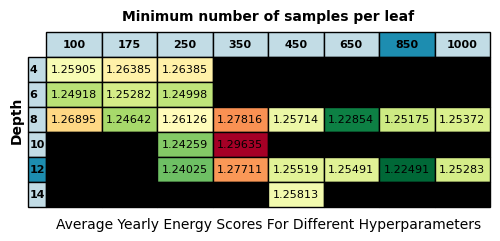

In [116]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
import seaborn as sns

mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
# Reset index to convert MultiIndex to columns
sorted_es_reset = sorted_es.reset_index()

# Extract Depth and Minimum number of samples from the 'level_0' column
depth_values = sorted_es_reset['level_0'].str.extract(r'D(\d+)_M(\d+)')
sorted_es_reset['Depth'] = depth_values[0].astype(int)
sorted_es_reset['Min_Samples'] = depth_values[1].astype(int)

# Pivot the DataFrame
pivot_df = sorted_es_reset.pivot(index='Depth', columns='Min_Samples', values='ES')

# Sort the index and columns for better readability
pivot_df = pivot_df.sort_index().sort_index(axis=1)

# Round the values to 5 decimal places
pivot_df = pivot_df.round(5)

# Create a normalized version of the DataFrame for colormap
norm = Normalize(vmin=pivot_df.min().min(), vmax=pivot_df.max().max())

# Create the plot and table
fig, ax = plt.subplots(figsize=(3, 2.5))  # Adjust figsize to fit your content
ax.axis('tight')
ax.axis('off')

# Create the table with the heatmap colors
heatmap_colors = plt.cm.RdYlGn_r(norm(pivot_df.values))

# Overwrite the colors for NaN values with black
nan_color = np.array([0, 0, 0, 1])  # RGBA for black
heatmap_colors[np.isnan(pivot_df.values)] = nan_color

# Find the cell with the minimum value
min_val_location = np.unravel_index(np.nanargmin(pivot_df.values), pivot_df.shape)
min_val_depth = pivot_df.index[min_val_location[0]]
min_val_min_samples = pivot_df.columns[min_val_location[1]]

# Get the color for the minimum value
min_val_color = plt.cm.RdYlGn_r(norm(pivot_df.min().min()))

# Create the table
table = ax.table(cellText=pivot_df.values,
                 cellColours=heatmap_colors,
                 colLabels=pivot_df.columns,
                 rowLabels=pivot_df.index,
                 cellLoc='center',
                 loc='center')

# Style the table
table.auto_set_font_size(False)
table.set_fontsize(8)
table.scale(1.2, 1.5)  # Scale columns by 1.2 and rows by 1.5

# Adjust the position of the table
table.auto_set_column_width(col=list(range(len(pivot_df.columns))))

# Add text annotations for row and column labels
plt.text(-0.55, 0.5, 'Depth', va='center', ha='right', fontsize=10, fontweight='bold', transform=ax.transAxes, rotation=90)
plt.text(0.5, 1, 'Minimum number of samples per leaf', va='bottom', ha='center', fontsize=10, fontweight='bold', transform=ax.transAxes)
plt.text(0.5, -0.08, 'Average Yearly Energy Scores For Different Hyperparameters', va='bottom', ha='center', fontsize=10, transform=ax.transAxes)

base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)
# Update the font properties for the row and column labels in the table
for key, cell in table.get_celld().items():
    if key[0] == 0 or key[1] == -1:  # Column labels or Row labels
        cell.set_text_props(fontweight='bold')
        cell.set_facecolor(palette[3])  # Set background color for row and column labels

# Highlight the row and column labels for the minimum value
for key, cell in table.get_celld().items():
    if key[0] == 0 and key[1] == min_val_location[1] :  # Column labels for min value
        cell.set_facecolor(palette[14])
    if key[1] == -1 and key[0] == min_val_location[0] + 1:  # Row labels for min value
        cell.set_facecolor(palette[14])

# Save the table as a PNG file with a transparent background
plt.savefig('Pictures/tuningflanders.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [117]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlanders/ThesisResults'), nb_of_samples = 250)
    .add_methods(
        Random_Baseline = RandomGenerator(),
        PCT_D8_M650 = PredClusGenerator(DecisionTreeRegressor(max_depth = 8, min_samples_leaf = 650)),
    )
    .add_datasets(
       
        flanders_dataset_baseline = flanders_dataset(),
         )
)

energy_scores, timing_df = experiment.execute()





Methods:   0%|          | 0/2 [00:00<?, ?it/s, method=Random_Baseline]

Methods: 100%|██████████| 2/2 [00:00<00:00, 23.51it/s, method=PCT_D8_M650]


In [118]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

experiment = (
    ComparisonExperiment(result_path = Path('resultsFlanders/ThesisResults'), nb_of_samples = 250)
    .add_methods(
        
        PCT_D12_M850 = PredClusGenerator(DecisionTreeRegressor(max_depth = 12, min_samples_leaf = 850)),
    )
    .add_datasets(
        flanders_dataset_with_buffer_jan = flanders_dataset_with_buffer('buffer_attributes_month_1_all_df.pkl'),
        flanders_dataset_with_buffer_feb = flanders_dataset_with_buffer('buffer_attributes_month_2_all_df.pkl'),
        flanders_dataset_with_buffer_mar = flanders_dataset_with_buffer('buffer_attributes_month_3_all_df.pkl'),
        flanders_dataset_with_buffer_apr = flanders_dataset_with_buffer('buffer_attributes_month_4_all_df.pkl'),
        flanders_dataset_with_buffer_may = flanders_dataset_with_buffer('buffer_attributes_month_5_all_df.pkl'),
        flanders_dataset_with_buffer_jun = flanders_dataset_with_buffer('buffer_attributes_month_6_all_df.pkl'),
        flanders_dataset_with_buffer_jul = flanders_dataset_with_buffer('buffer_attributes_month_7_all_df.pkl'),
        flanders_dataset_with_buffer_aug = flanders_dataset_with_buffer('buffer_attributes_month_8_all_df.pkl'),
        flanders_dataset_with_buffer_sep = flanders_dataset_with_buffer('buffer_attributes_month_9_all_df.pkl'),
        flanders_dataset_with_buffer_oct = flanders_dataset_with_buffer('buffer_attributes_month_10_all_df.pkl'),
        flanders_dataset_with_buffer_nov = flanders_dataset_with_buffer('buffer_attributes_month_11_all_df.pkl'),
        flanders_dataset_with_buffer_dec = flanders_dataset_with_buffer('buffer_attributes_month_12_all_df.pkl'),
        )
)

energy_scores2, timing_df2 = experiment.execute()
energy_scores = pd.concat([energy_scores, energy_scores2], axis=1)





Methods: 100%|██████████| 1/1 [00:00<00:00,  9.23it/s, method=PCT_D12_M850]


In [119]:
mean_es = energy_scores.mean(axis=0).to_frame('ES')
sorted_es = mean_es.sort_values(by='ES')
display(sorted_es)

ES
PCT_D8_M650     flanders_dataset_baseline         1.211430
PCT_D12_M850    flanders_dataset_with_buffer_feb  1.225073
                flanders_dataset_with_buffer_apr  1.225991
                flanders_dataset_with_buffer_sep  1.226668
                flanders_dataset_with_buffer_jun  1.226745
                flanders_dataset_with_buffer_mar  1.227184
                flanders_dataset_with_buffer_dec  1.230072
                flanders_dataset_with_buffer_jul  1.230767
                flanders_dataset_with_buffer_may  1.231915
                flanders_dataset_with_buffer_nov  1.236298
                flanders_dataset_with_buffer_oct  1.243904
                flanders_dataset_with_buffer_jan  1.250200
                flanders_dataset_with_buffer_aug  1.257665
Random_Baseline flanders_dataset_baseline         1.540731

In [120]:
# set the correct index to the energy scores
ldf = flanders_dataset()
merged_attributes, timeseries, folds = ldf
energy_scores.index = timeseries.index
energy_scores = energy_scores.droplevel('meterID')
energy_scores.index

DatetimeIndex(['2021-01-01', '2021-01-02', '2021-01-03', '2021-01-04',
               '2021-01-05', '2021-01-06', '2021-01-07', '2021-01-08',
               '2021-01-09', '2021-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=36500, freq=None)

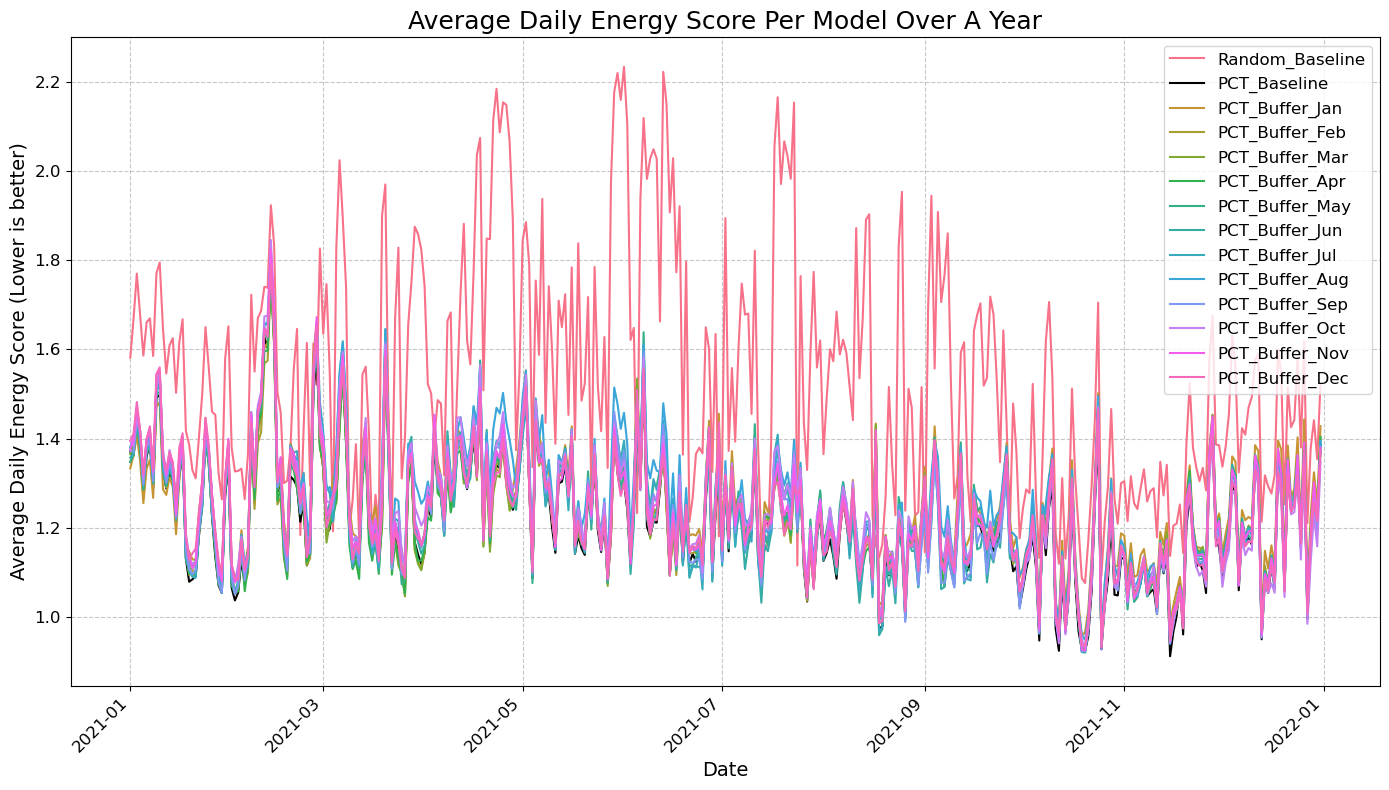

In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Group by 'date' and calculate the mean and standard deviation for each day
df_avg = energy_scores.groupby('date').mean()
# df_std = energy_scores.groupby('date').std()

# Set a seaborn color palette
sns.set_palette("husl", len(df_avg.columns))

# Custom legend names
custom_legend_names = [
    'Random_Baseline',    
    'PCT_Baseline',       
    'PCT_Buffer_Jan',
    'PCT_Buffer_Feb',
    'PCT_Buffer_Mar',
    'PCT_Buffer_Apr',
    'PCT_Buffer_May',
    'PCT_Buffer_Jun',
    'PCT_Buffer_Jul',
    'PCT_Buffer_Aug',
    'PCT_Buffer_Sep',
    'PCT_Buffer_Oct',
    'PCT_Buffer_Nov',
    'PCT_Buffer_Dec'
]

# Plot the averages for all columns dynamically with different colors
plt.figure(figsize=(14, 8))

# Iterate over all columns and plot them with different colors
for i, column in enumerate(df_avg.columns):
    color = sns.color_palette()[i]  # Use seaborn color palette
    if i == 1:
        color = 'black'
    plt.plot(df_avg.index, df_avg[column], linestyle='-', color=color, label=custom_legend_names[i])

# Set plot aesthetics
plt.title('Average Daily Energy Score Per Model Over A Year', fontsize=18)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Average Daily Energy Score (Lower is better)', fontsize=14)
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.legend(loc='upper right',fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

plt.savefig('pictures/flandersyeargraph.png', bbox_inches='tight', dpi=300, transparent=True)

# Display the plot
plt.show()


In [122]:
for i in range(1,14):
    technique_A = df_avg.iloc[:, 1]
    technique_B = df_avg.iloc[:, i]
    percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
    percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
    print("lower in A: ", percentage_A_greater_than_B)

lower in A:  0.0
lower in A:  8.767123287671232
lower in A:  21.36986301369863
lower in A:  18.63013698630137
lower in A:  23.013698630136986
lower in A:  18.08219178082192
lower in A:  27.945205479452056
lower in A:  22.465753424657535
lower in A:  3.0136986301369864
lower in A:  20.82191780821918
lower in A:  10.41095890410959
lower in A:  6.027397260273973
lower in A:  15.342465753424658


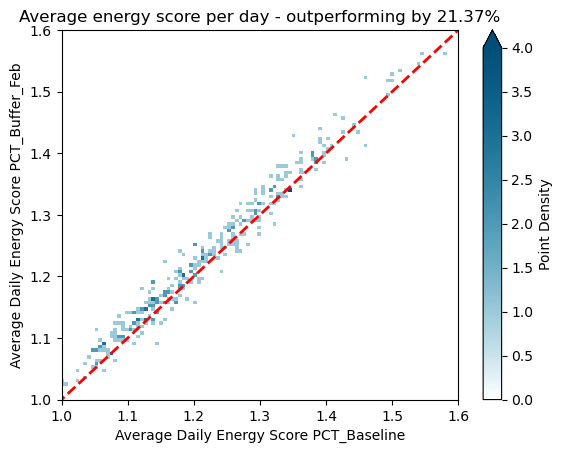

In [123]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap

df_avg = energy_scores.groupby('date').mean()
technique_A = df_avg.iloc[:, 1]
technique_B = df_avg.iloc[:, 3]

# Increase bin size for a smoother heatmap
bin_size = 150

# Define the end color (#1D8DB0)
end_color = [0.114, 0.553, 0.690]  # RGB values

# Create a custom colormap starting from white to the end color with increased saturation
cmap_white_to_custom = LinearSegmentedColormap.from_list('white_to_custom', [(1, 1, 1), end_color], N=256)

# Create a modified colormap with increased saturation
cmap_white_to_custom_saturation = ListedColormap(cmap_white_to_custom(np.linspace(0, 1, 256))[:, :3] ** 2)

# Use the custom colormap in hist2d
heatmap = plt.hist2d(technique_A, technique_B, bins=bin_size, cmap=cmap_white_to_custom_saturation)

# Add a 45-degree line
plt.plot([0, 3], [0, 3], color='red', linestyle='--', linewidth=2)

# Add labels and title
plt.xlabel('Average Daily Energy Score PCT_Baseline')
plt.ylabel('Average Daily Energy Score PCT_Buffer_Feb')
percentage_A_greater_than_B = (technique_A > technique_B).sum() / len(technique_A) * 100
percentage_B_greater_than_A = (technique_B > technique_A).sum() / len(technique_A) * 100
plt.title(f'Average energy score per day - outperforming by {percentage_A_greater_than_B:.2f}%')

# Add colorbar with white indicating zero density
cbar = plt.colorbar(heatmap[3], label='Point Density', cmap=cmap_white_to_custom_saturation, extend='max')

plt.xlim(1, 1.6)
plt.ylim(1, 1.6)
# Show the plot
plt.savefig('pictures/flandersdailycomparison.png', bbox_inches='tight', dpi=300, transparent=True)

plt.show()

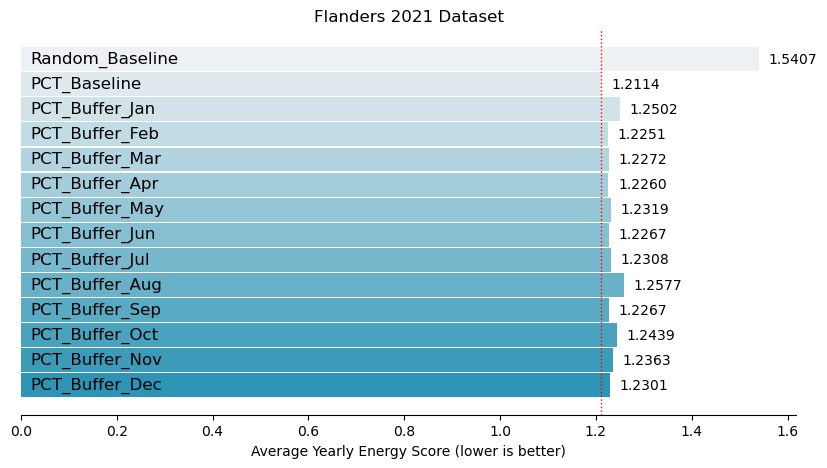

In [124]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


# Mock example data
techniques = ['Random_Baseline', 'PCT_Baseline']
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Create a new list with entries for each month
extended_list = [f'PCT_Buffer_{month}' for month in months]
values = []
values.extend(energy_scores.mean(axis = 0).values.tolist())
techniques.extend(extended_list)

# Define a list of colors (include more than 4 colors for potential future use)
base_color = '#1D8DB0'
palette = sns.light_palette(base_color, n_colors=15)

# Use the first four colors for the current bars
#bar_colors = all_colors[:len(techniques)]

# Calculate positions for bars
bar_positions = np.arange(len(techniques))

# Plotting
fig, ax = plt.subplots(figsize=(10, 5))
bar_width = 0.2  # Adjust the width of the bars
bar_spacing = 0.01  # Adjust the spacing between the bars

bars = ax.barh(bar_positions * (bar_width + bar_spacing), values, color=palette, height=bar_width)

# Adding values and standard deviations at the end of each bar
for bar, technique, value,  in zip(bars, techniques, values):
    decimals = 4 if str(value)[::-1].find('.') >= 2 else 2
    value_text = f'{value:.{decimals}f}'
    ax.text(bar.get_width() + 0.02, bar.get_y() + bar_width / 2, value_text, ha='left', va='center', fontsize=10, color='black')
    ax.text(bar.get_x() + 0.02, bar.get_y() + bar_width / 2, technique, ha='left', va='center', fontsize=12, color='black')

# Add a thin dotted red vertical line at the value of index 1 in the values list
ax.axvline(x=values[1], color='red', linestyle=':', linewidth=1)

# Customize plot
ax.set_yticks([])  # Remove y-axis ticks
ax.invert_yaxis()  # Invert y-axis to have the first technique at the top

# Remove box edges
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

# Set labels and title
ax.set_xlabel('Average Yearly Energy Score (lower is better)')
ax.set_title('Flanders 2021 Dataset')
plt.savefig('pictures/energy_score_comparison_flanders.png', bbox_inches='tight', dpi=300, transparent=True)
# Show plot
plt.show()


In [125]:
import pandas as pd
# Drop the first column by using its index as randombaseline should not be included
energy_scores = energy_scores.drop(energy_scores.columns[0], axis=1)
# Assuming energy_scores is your DataFrame

# Convert the index to a datetime object
energy_scores.index = pd.to_datetime(energy_scores.index)

# Extract the month from the datetime index
energy_scores['Month'] = energy_scores.index.month

# Initialize an empty DataFrame for the final table
monthly_means = pd.DataFrame()

# Calculate the mean for each month for each column
for month in range(1, 13):
    monthly_mean = energy_scores[energy_scores['Month'] == month].mean()
    monthly_means[month] = monthly_mean

# Drop the 'Month' row as it's not needed in the final table
monthly_means = monthly_means.drop('Month')

# Rename the index for clarity
monthly_means.index = ['PCT_Baseline', 'PCT_Buffer_Jan', 'PCT_Buffer_Feb', 'PCT_Buffer_Mar', 'PCT_Buffer_Apr', 'PCT_Buffer_May', 'PCT_Buffer_Jun', 'PCT_Buffer_Jul', 'PCT_Buffer_Aug', 'PCT_Buffer_Sep', 'PCT_Buffer_Oct', 'PCT_Buffer_Nov', 'PCT_Buffer_Dec']

# Rename the columns to represent months
monthly_means.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

# Display the table
display(monthly_means)


/var/folders/_3/h0p_y99n15v6k84rsz9x28h40000gn/T/ipykernel_37470/1576532215.py:21: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  monthly_means = monthly_means.drop('Month')


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,1.279367,1.308061,1.242493,1.303792,1.264736,1.231009,1.208749,1.139428,1.177823,1.089862,1.106852,1.193489
PCT_Buffer_Jan,1.287360,1.346429,1.286384,1.332246,1.303650,1.262701,1.232758,1.177265,1.224198,1.150590,1.157913,1.249458
PCT_Buffer_Feb,1.295640,1.305551,1.239418,1.304232,1.278302,1.244263,1.215200,1.160992,1.194556,1.119046,1.135400,1.215354
PCT_Buffer_Mar,1.299970,1.328960,1.234152,1.303449,1.281075,1.245535,1.216238,1.163753,1.196428,1.115524,1.135048,1.215015
PCT_Buffer_Apr,1.290707,1.308913,1.229132,1.302292,1.287541,1.258264,1.223835,1.166521,1.198607,1.114013,1.127887,1.211661
PCT_Buffer_May,1.283137,1.330030,1.252322,1.317928,1.286257,1.272770,1.235180,1.168084,1.205823,1.113778,1.118304,1.208449
PCT_Buffer_Jun,1.312742,1.344561,1.266498,1.330620,1.283771,1.229046,1.200917,1.134938,1.159161,1.114193,1.133025,1.221093
PCT_Buffer_Jul,1.291086,1.345648,1.275144,1.328013,1.283022,1.260005,1.219761,1.147628,1.186847,1.118095,1.118356,1.205754
PCT_Buffer_Aug,1.311212,1.353918,1.302476,1.373206,1.328196,1.301204,1.243818,1.170017,1.234161,1.144522,1.132182,1.206705
PCT_Buffer_Sep,1.295655,1.331909,1.264133,1.327334,1.289930,1.256101,1.221122,1.151425,1.163114,1.109704,1.120480,1.198021


In [126]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

# Assuming monthly_means is your DataFrame after calculating the means

# Function to normalize data and apply color gradient within each column
def color_gradient(val, min_val, max_val, base_val):
    dif_lower = base_val - min_val
    dif_higher = max_val - base_val
    if dif_lower < dif_higher:
        min_val -= (dif_higher - dif_lower)
    elif dif_higher < dif_lower:
        max_val += (dif_lower - dif_higher)
    
    # Normalize the value within the column
    norm = mcolors.Normalize(vmin=min_val, vmax=max_val)
    # Use RdYlGn colormap (Red to Green)
    color = plt.cm.RdYlGn_r(norm(val))  # _r reverses the colormap
    # Convert color to hex format
    return f'background-color: {mcolors.to_hex(color)}; color: black'

# Function to round values, apply color gradient, and conditionally bold text
def apply_style(x):
    base_val = x[0]  # Assuming the first value is the baseline
    styled_cells = []
    for v in x:
        style = color_gradient(v, min(x), max(x), base_val)
        if v < base_val:
            style += '; font-weight: bold'
        styled_cells.append(f'{style}; text-align: right')
    return styled_cells

# Apply the color mapping and rounding to each cell within its column
styled_table = (monthly_means
                .round(5)
                .style
                .apply(apply_style, axis=0)
                .format("{:.5f}")
                .set_caption("<b style='font-size:15px;'>Average Monthly Energy Score Per Model (Rows) Per Month (Columns) With PCT_Baseline Comparison</b>"))

# Display the styled table
styled_table


,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
PCT_Baseline,1.27937,1.30806,1.24249,1.30379,1.26474,1.23101,1.20875,1.13943,1.17782,1.08986,1.10685,1.19349
PCT_Buffer_Jan,1.28736,1.34643,1.28638,1.33225,1.30365,1.26270,1.23276,1.17727,1.22420,1.15059,1.15791,1.24946
PCT_Buffer_Feb,1.29564,1.30555,1.23942,1.30423,1.27830,1.24426,1.21520,1.16099,1.19456,1.11905,1.13540,1.21535
PCT_Buffer_Mar,1.29997,1.32896,1.23415,1.30345,1.28107,1.24554,1.21624,1.16375,1.19643,1.11552,1.13505,1.21502
PCT_Buffer_Apr,1.29071,1.30891,1.22913,1.30229,1.28754,1.25826,1.22383,1.16652,1.19861,1.11401,1.12789,1.21166
PCT_Buffer_May,1.28314,1.33003,1.25232,1.31793,1.28626,1.27277,1.23518,1.16808,1.20582,1.11378,1.11830,1.20845
PCT_Buffer_Jun,1.31274,1.34456,1.26650,1.33062,1.28377,1.22905,1.20092,1.13494,1.15916,1.11419,1.13303,1.22109
PCT_Buffer_Jul,1.29109,1.34565,1.27514,1.32801,1.28302,1.26000,1.21976,1.14763,1.18685,1.11810,1.11836,1.20575
PCT_Buffer_Aug,1.31121,1.35392,1.30248,1.37321,1.32820,1.30120,1.24382,1.17002,1.23416,1.14452,1.13218,1.20670
PCT_Buffer_Sep,1.29565,1.33191,1.26413,1.32733,1.28993,1.25610,1.22112,1.15143,1.16311,1.10970,1.12048,1.19802
